## Melanoma Detection Assignment

### Objective:

1. Build a model based on CNN to detect melanoma accurately
2. Detect images into the 9 classes
3. Handle class imbalances using augmentor library
4. Identify and prevent underfitting and overfitting

---
#### GOAL

**Detect images and classify into 9 classes**

---
#### Steps
---

1. Understand Data
2. Data Visualization
3. Build CNN Model
4. a. Rescale images
5. b. Choose optimizer and loss functions
6. c. Check model for underfitting/ overfitting
7. d. Choose augmentation strategy
8. e. Handle class imbalances
9. Build and train model on the rectified class imbalance data

##### Import Libraries

In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Sequential


# Warnings library
import warnings #warning
warnings.filterwarnings('ignore')

tf.config.run_functions_eagerly(True)

In [2]:
# Path to directories

# data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
# data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

data_dir_train = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2245
118


---
### <font color="purple">Dataset Creation</font>

In [7]:
batch_size = 32
img_height = 180
img_width = 180
class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

In [9]:
# Training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode='int',
    labels='inferred',
    class_names=class_names,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
# Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode='int',
    labels='inferred',
    class_names=class_names,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
# Test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_test,
    validation_split=0.0,
    seed=123,
    label_mode='int',
    labels='inferred',
    class_names=class_names,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2245 files belonging to 9 classes.
Using 1796 files for training.
Found 2245 files belonging to 9 classes.
Using 449 files for validation.
Found 118 files belonging to 9 classes.


---
### <font color="purple">Dataset Visualisation</font>

**Display sample image from each type of class**

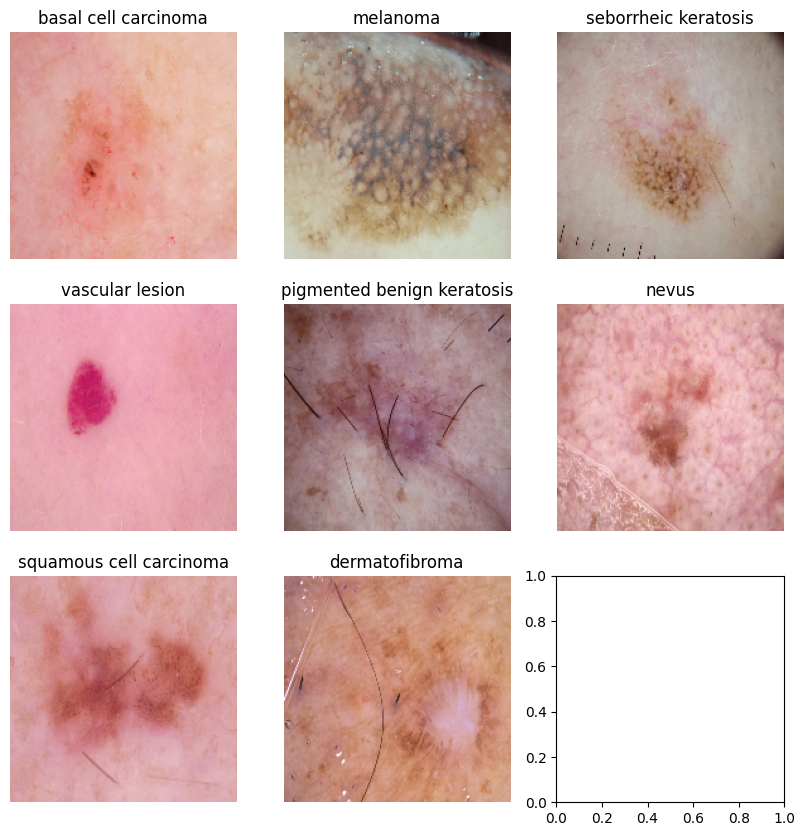

In [10]:
import matplotlib.pyplot as plt

def visualise_data(train_ds, class_names):
    image_batch, label_batch = next(iter(train_ds))

    # Plot one image from each class
    class_indices = []
    classes = train_ds.class_names
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))  # Adjust according to the number of classes
    axs = axs.ravel()

    for i, label in enumerate(label_batch):
        # Only plot one image per class
        if label.numpy() not in class_indices:
            class_indices.append(label.numpy())
            axs[len(class_indices)-1].imshow(image_batch[i].numpy().astype("uint8"))  # Take individual image from batch
            axs[len(class_indices)-1].set_title(classes[label])
            axs[len(class_indices)-1].axis('off')

        # Stop when we've plotted one image from each class
        if len(class_indices) == len(classes):
            break

    plt.show()

visualise_data (train_ds, class_names)

---
### <font color="purple">Visualise class distribution</font>
**Class with least no. of samples** <br/>
**Classes that dominate the data in terms of proportionate no. of samples**

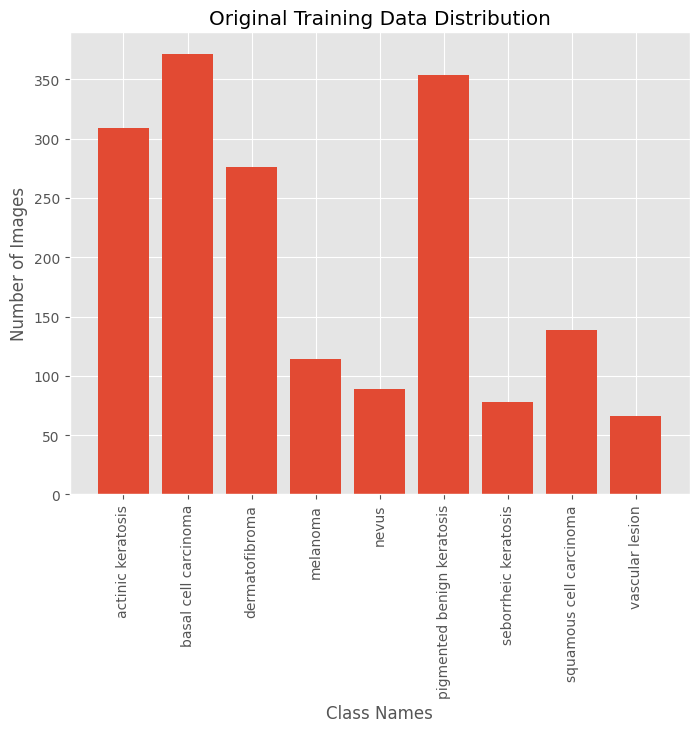

In [14]:
class_counts = {class_name: 0 for class_name in class_names}
from collections import Counter

# Function to create augmentor pipeline for each class
def visualize_distribution(dataset, title):
    class_names = dataset.class_names
    class_counts = Counter([label.numpy() for _, labels in dataset for label in labels])
    plt.style.use('ggplot')
    plt.figure(figsize=(8, 6))
    plt.bar(class_names, class_counts.values())
    plt.xlabel('Class Names')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

visualize_distribution(train_ds, "Original Training Data Distribution")


### <font color="green">Conclusion</font>
**Class with least no. of samples** - seborrheic keratosis <br/>
**Classes that dominate the data in terms of proportionate no. of samples** - pigmented benign keratosis

---
### <font color="purple">Model Building and training</font>


---
<h3><font color="brown">Rescale Data</font></h3>

In [15]:
# Rescale images to normalise values between [0,1] scale
from tensorflow.keras.layers import Rescaling
rescaling_layer = Rescaling(1./255)

train_ds_rescaled = train_ds.map(lambda x, y: (rescaling_layer(x), y))
val_ds_rescaled = val_ds.map(lambda x, y: (rescaling_layer(x), y))
test_ds_rescaled = test_ds.map(lambda x, y: (rescaling_layer(x), y))

---
<h3><font color="brown">Model 1 - CNN model</font></h3>

In [13]:
# Build CNN model
model_1 = Sequential()

model_1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3))),
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Conv2D(64, (3, 3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Conv2D(128, (3, 3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Flatten())
model_1.add(Dense(512, activation='relu'))
model_1.add(Dense(len(class_names), activation='softmax'))  # Multi-class classification uses softmax


# Compile the model
model_1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy if labels are integers
    metrics=['accuracy']
)



In [42]:
model_1.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │      26,214,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,312,777 (100.38 MB)

 Trainable params: 26,312,777 (100.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model with validation data
history = model_1.fit(
    train_ds_rescaled,
    validation_data=val_ds_rescaled,
    epochs=20
)

# Evaluate the model on the test set
test_loss, test_accuracy = model_1.evaluate(test_ds_rescaled)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Make predictions on the test set
predictions = model_1.predict(test_ds_rescaled)

# Plot training and validation loss curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 452ms/step - accuracy: 0.2199 - loss: 2.5788 - val_accuracy: 0.3541 - val_loss: 1.7989
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 36s 379ms/step - accuracy: 0.4070 - loss: 1.7159 - val_accuracy: 0.4521 - val_loss: 1.6210
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 388ms/step - accuracy: 0.4444 - loss: 1.5181 - val_accuracy: 0.4788 - val_loss: 1.4335
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 385ms/step - accuracy: 0.4976 - loss: 1.4062 - val_accuracy: 0.4187 - val_loss: 1.6524
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.4829 - loss: 1.4187 - val_accuracy: 0.4543 - val_loss: 1.6064
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 390ms/step - accuracy: 0.5472 - loss: 1.3084 - val_accuracy: 0.5345 - val_loss: 1.3940
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 385ms/step - accuracy: 0.5824 - loss: 1.2039 - val_accuracy: 0.5234 - val_loss: 1.3057
Epoch 8/20


### <font color="green">Conclusion for Model 1</font>
<ol>
    <b>Model is Overfitting</b>
   <li>As per the graph: Training loss is decreasing and validation loss is increasing which is a clear indication of overfitting. The model is learning noise alongside patterns in training data </li>
    <li>Another evidence to overfitting is the accuracy scores for training data are drastically higher than the test data. This happens when the model is not able to generalise very well</li>
</ol>
<br/>
<ol>
    <b>How to fix overfitting in CNN</b>
    <li>Data Augmentation</li>
    <li>Dropout Layers</li>
    <li>Regularization</li>
    <li>Reduce Model Complexity</li>
    <li>Early Stopping	</li>
    <li>Increase Training Data	</li>
</ol>

---

<h3><font color="brown">Model 2</font></h3>

**1. Apply data augmentation to reduce overfitting** <br/>
**2. Apply Adam optimizer** <br/>
**3. Add Dropout layers** <br/>

In [ ]:
# Build CNN model
model_2 = Sequential()
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

train_ds_rescaled = train_ds_rescaled.map(lambda x, y: (data_augmentation(x, training=True), y))
val_ds_rescaled = val_ds_rescaled.map(lambda x, y: (data_augmentation(x, training=True), y))

# Data augmentation using random zoom and rotation
model_2.add(data_augmentation)

model_2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3))),
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))
model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))
model_2.add(Conv2D(128, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))
model_2.add(Flatten())
model_2.add(Dense(512, activation='relu'))
model_2.add(Dense(len(class_names), activation='softmax'))  # Multi-class classification uses softmax



# Compile the model
model_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy if labels are integers
    metrics=['accuracy']
)



In [ ]:
model_2.summary()

In [ ]:
# Train the model with validation data
history = model_2.fit(
    train_ds_rescaled,
    validation_data=val_ds_rescaled,
    epochs=20
)

# Evaluate the model on the test set
test_loss_2, test_accuracy_2 = model_2.evaluate(test_ds_rescaled)
print(f'Test Loss: {test_loss_2}, Test Accuracy: {test_accuracy_2}')

# Make predictions on the test set
predictions = model_2.predict(test_ds_rescaled)

# Plot training and validation loss curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### <font color="green">Conclusion for Model 2</font>
<ol>
    <b>Overfitting</b>
    <li>As per the graph: Training and validation loss values are reducing to nearby values which indicates that overfitting is taken care of </li>
    <b>Accuracy</b>
    <li>Train and test accuracy scores are still low</li>
</ol>
<br/>
<ol>
    <b>How to increase Accuracy Score</b>
    <li>Data Augmentation</li>
    <li>Data normalization</li>
    <li>Batch normalization</li>
    <li>Learning rate scheduling</li>
    <li>Weight Decay</li>
    <li>Gradient clipping</li>
</ol>

---

<h3><font color="brown">Model 3</font></h3>

**1. Handle Class imbalances using augmentor library** <br/>
**2. Learning rate scheduling** <br/>
**3. Weight decay** <br/>


In [16]:
!pip install augmentor

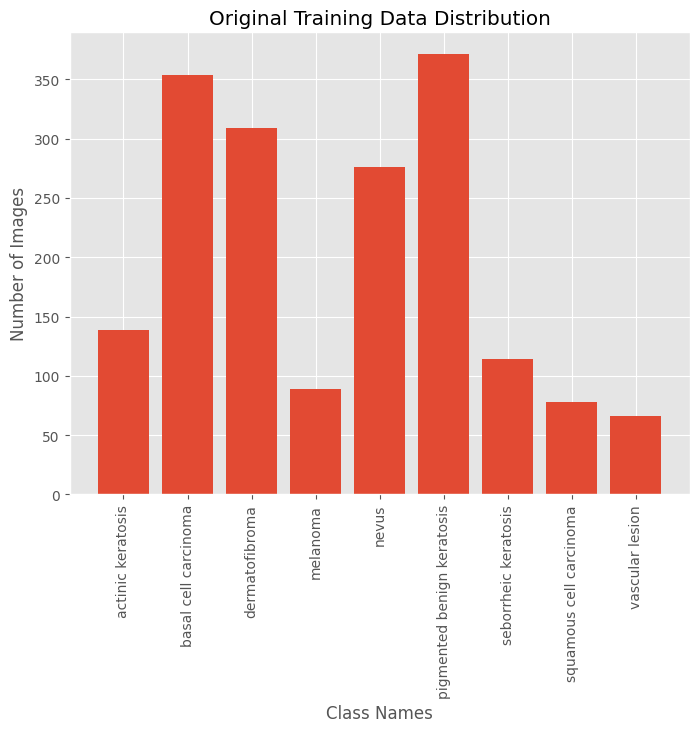

In [17]:
import Augmentor

# Display the original class distribution
visualize_distribution(train_ds, "Original Training Data Distribution")


In [18]:
for i in class_names:
    p = Augmentor.Pipeline(data_dir_train)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.zoom_random(probability=0.5, percentage_area=0.8)
    p.flip_left_right(probability=0.5)
    p.sample(1000)

Initialised with 2245 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D4698364B20>: 100%|██████████| 1000/1000 [02:07<00:00,  7.85 Samples/s]


Initialised with 2245 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7D469D0227D0>: 100%|██████████| 1000/1000 [02:04<00:00,  8.05 Samples/s]


Initialised with 2245 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D469CF2A0E0>: 100%|██████████| 1000/1000 [01:58<00:00,  8.44 Samples/s]


Initialised with 2245 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1936x1936 at 0x7D46982F2110>: 100%|██████████| 1000/1000 [01:54<00:00,  8.77 Samples/s]


Initialised with 2245 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D472371C370>: 100%|██████████| 1000/1000 [02:04<00:00,  8.04 Samples/s]


Initialised with 2245 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D4698240E20>: 100%|██████████| 1000/1000 [01:56<00:00,  8.62 Samples/s]


Initialised with 2245 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D469CFEE500>: 100%|██████████| 1000/1000 [01:55<00:00,  8.66 Samples/s]


Initialised with 2245 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7D46983A2440>: 100%|██████████| 1000/1000 [02:03<00:00,  8.11 Samples/s]


Initialised with 2245 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=959x723 at 0x7D46982408B0>: 100%|██████████| 1000/1000 [02:03<00:00,  8.11 Samples/s]


Found 9000 files belonging to 9 classes.


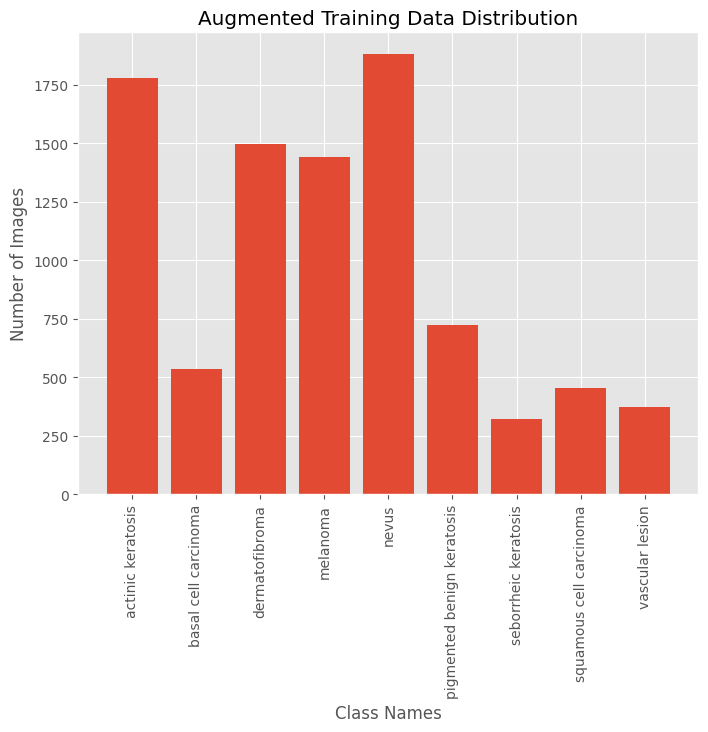

In [19]:
# augmented_data_dir = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train/output/")
augmented_data_dir = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output/")

augmented_train_ds = tf.keras.utils.image_dataset_from_directory(
    augmented_data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Display the augmented data distribution
visualize_distribution(augmented_train_ds, "Augmented Training Data Distribution")

In [20]:
image_count_train = len(list(augmented_data_dir.glob('*/*.jpg')))
print(image_count_train)

9000


In [21]:
# Augmented training data
augmented_train_ds = augmented_train_ds.map(lambda x, y: (rescaling_layer(x), y))

# Build CNN model
model_3 = Sequential()
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

augmented_train_ds = augmented_train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
val_ds_rescaled = val_ds_rescaled.map(lambda x, y: (data_augmentation(x, training=True), y))

# Data augmentation using random zoom and rotation
model_3.add(data_augmentation)

model_3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3))),
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.3))
model_3.add(Conv2D(64, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.3))
model_3.add(Conv2D(128, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.3))
model_3.add(Flatten())
model_3.add(Dense(512, activation='relu'))
model_3.add(Dense(len(class_names), activation='softmax'))  # Multi-class classification uses softmax

# Compile the model
model_3.compile(
    optimizer=tf.keras.optimizers.Adam(
      learning_rate=0.001),
    loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy if labels are integers
    metrics=['accuracy']
)

model_3.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model with validation data
history = model_3.fit(
    augmented_train_ds,
    validation_data=val_ds_rescaled,
    epochs=30
)

Epoch 1/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 1247s 4s/step - accuracy: 0.2283 - loss: 2.7636 - val_accuracy: 0.3853 - val_loss: 1.6446
Epoch 2/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 1175s 4s/step - accuracy: 0.4344 - loss: 1.5601 - val_accuracy: 0.4833 - val_loss: 1.4515
Epoch 3/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 1194s 4s/step - accuracy: 0.4783 - loss: 1.4768 - val_accuracy: 0.4855 - val_loss: 1.4118
Epoch 4/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 1193s 4s/step - accuracy: 0.5146 - loss: 1.3809 - val_accuracy: 0.4454 - val_loss: 1.5288
Epoch 5/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 1270s 4s/step - accuracy: 0.5413 - loss: 1.3048 - val_accuracy: 0.5278 - val_loss: 1.3115
Epoch 6/30
260/282 ━━━━━━━━━━━━━━━━━━━━ 1:33 4s/step - accuracy: 0.5365 - loss: 1.2974

In [ ]:

# Evaluate the model on the test set
test_loss_3, test_accuracy_3 = model_3.evaluate(test_ds_rescaled)
print(f'Test Loss: {test_loss_3}, Test Accuracy: {test_accuracy_3}')

# Make predictions on the test set
predictions = model_3.predict(test_ds_rescaled)

# Plot training and validation loss curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### <font color="green">Conclusion for Model 3</font>
<ol>
    <b>Accuracy</b>
    <li>Train and test accuracy scores have improved</li>
    <li>Adam optimizer is appropriate for multiclass classification<br/>
        <ol>
            <li>Enhanced Learning Dynamics</li>
            <li>Faster convergence</li>
            <li>Improved Generalization</li>
        </ol>
    </li>
</ol>

### <font color="green">Predicted Classes vs Actual classes from test set with 64% accuracy</font>

In [ ]:
predicted_classes = np.argmax(predictions, axis=1)

# Plot some test images with their predicted labels
plt.figure(figsize=(12, 12))
for images, labels in test_ds.take(1):  # Taking one batch from the test dataset
    for i in range(9):  # Display the first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_label = class_names[predicted_classes[i]]
        true_label = class_names[labels[i]]
        plt.title(f"True: {true_label}, Pred: {predicted_label}", fontsize=8)
        plt.axis("off")

plt.show()